In [49]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import time

In [45]:
# Load sentence transformer model
st_model = SentenceTransformer('all-MiniLM-L6-v2')

# Input sentences
texts = {
    "vec1": "The sky is blue.",
    "vec2": "The ocean is vast and blue.",
    "vec3": "Quantum computing is powerful.",
    "vec4": "Artificial intelligence is evolving fast.",
    "vec5": "The sky is blue.",
    "vec6": "The sky is blue and white and red.",
    "vec7": "The sky is blue and white and red and green.",
    "vec8": "The sky is blue and white and red and green and yellow.",
    "vec9": "The sky is blue and white and red and green and yellow and orange.",
    "vec10": "The sky is blue and white and red and green and yellow and orange and purple.",
}

# Step 1: Get sentence embeddings
embeddings = {key: st_model.encode(sentence) for key, sentence in texts.items()}

# Step 2: PCA + Normalize to [0, pi]
names = list(embeddings.keys())
X = np.array([embeddings[name] for name in names])

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X_pca)

vectors = {names[i]: list(X_scaled[i]) for i in range(len(names))}

/opt/miniconda3/envs/bbcrec/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [46]:
# Function to create the swap test circuit using layered entanglement
def create_swap_test_circuit(x1, x2, entangled=False):
    assert len(x1) == len(x2), "Input vectors must be the same length"
    n = len(x1)
    qc = QuantumCircuit(1 + 2 * n, 1)  # 1 control + n for phi + n for psi

    for i in range(n):
        qc.ry(x1[i], i + 1)
    if entangled:
        for i in range(n - 1):
            qc.cx(i + 1, i + 2)

    for i in range(n):
        qc.ry(x2[i], i + n + 1)
    if entangled:
        for i in range(n - 1):
            qc.cx(i + n + 1, i + n + 2)

    qc.h(0)
    for i in range(n):
        qc.cswap(0, i + 1, i + n + 1)
    qc.h(0)
    qc.measure(0, 0)

    return qc

# Function to run the circuit and calculate fidelity
def run_swap_test(qc):
    simulator = Aer.get_backend('aer_simulator')
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=1000).result()
    counts = result.get_counts()
    p0 = counts.get('0', 0) / 1000
    fidelity = 2 * p0 - 1
    return fidelity, counts

# Batch processing function
def batch_compare(reference_key, vectors_dict, entangled=False):
    results = {}
    ref_vec = vectors_dict[reference_key]
    for key, vec in vectors_dict.items():
        if key == reference_key:
            continue
        qc = create_swap_test_circuit(ref_vec, vec, entangled=entangled)
        fidelity, counts = run_swap_test(qc)
        results[key] = {"fidelity": fidelity, "counts": counts}
    return results

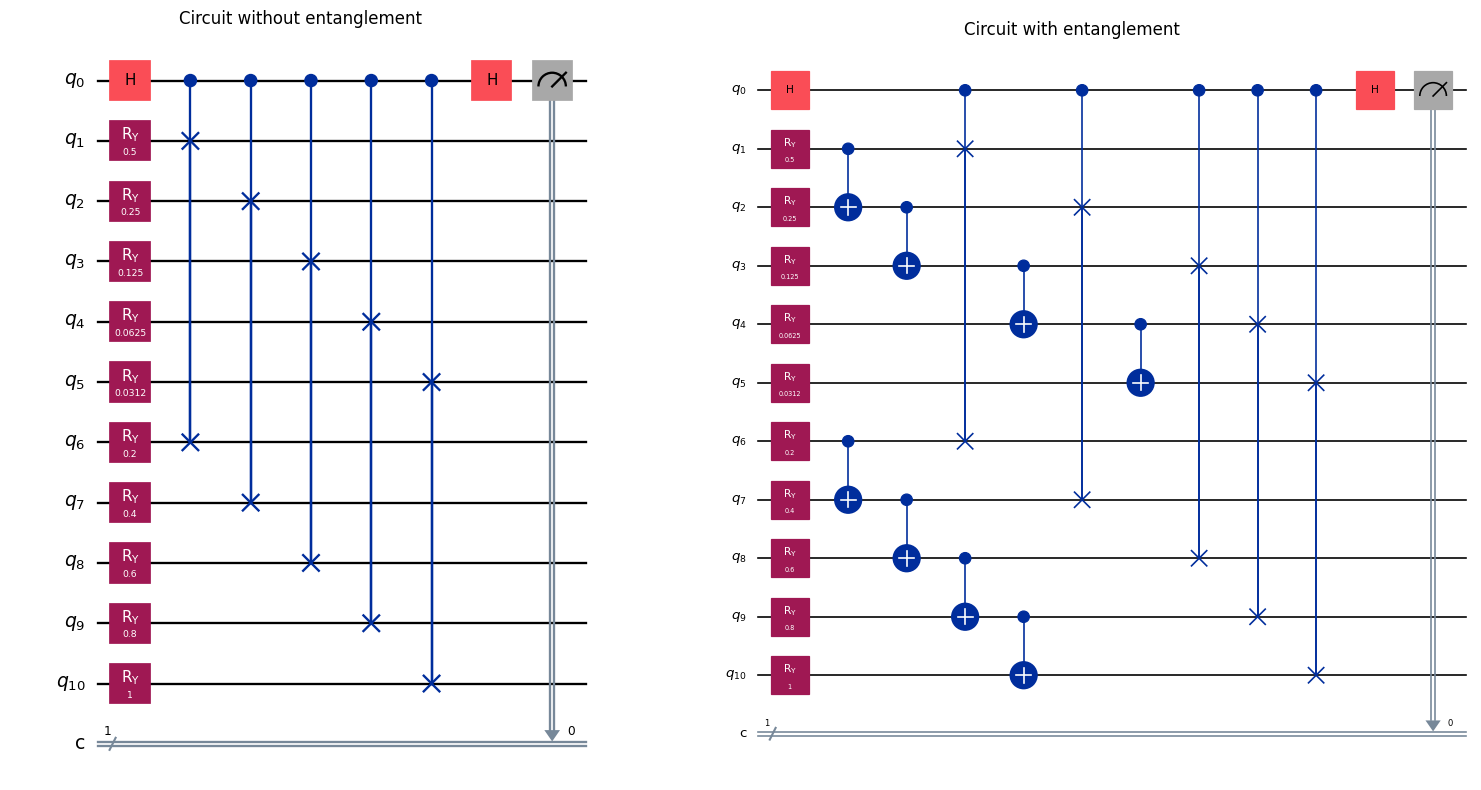

In [47]:
# sample swap test circuit
v1 = [0.5, 0.25, 0.125, 0.0625, 0.03125]
v2 = [0.2, 0.4, 0.6, 0.8, 1.0]
qc1 = create_swap_test_circuit(v1, v2, entangled=False)
qc2 = create_swap_test_circuit(v1, v2, entangled=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
qc1.draw(output='mpl', ax=ax1)
ax1.set_title('Circuit without entanglement')
qc2.draw(output='mpl', ax=ax2) 
ax2.set_title('Circuit with entanglement')
plt.tight_layout()

In [54]:
# Time the fidelity computations
start_fid = time.time()
results_no_ent = batch_compare("vec1", vectors, entangled=False)
results_ent = batch_compare("vec1", vectors, entangled=True)
end_fid = time.time()

# Time the cosine similarity computations
start_cos = time.time()
vec1 = embeddings["vec1"].reshape(1, -1)
cosine_full = {
    key: cosine_similarity(vec1, embeddings[key].reshape(1, -1))[0, 0]
    for key in embeddings if key != "vec1"
}
vec1_pca = X_pca[names.index("vec1")].reshape(1, -1)
cosine_pca = {
    key: cosine_similarity(vec1_pca, X_pca[names.index(key)].reshape(1, -1))[0, 0]
    for key in embeddings if key != "vec1"
}
end_cos = time.time()

# Print timing results
print(f"\nFidelity both entangled and non-entangled computation time: {end_fid - start_fid:.4f} seconds")
print(f"Cosine similarity computation time: {end_cos - start_cos:.4f} seconds")


Fidelity both entangled and non-entangled computation time: 0.9470 seconds
Cosine similarity computation time: 0.0027 seconds


No entanglement - vec1 and vec5, Results: {'fidelity': 1.0, 'counts': {'0': 1000}}
With entanglement - vec1 and vec5, Results: {'fidelity': 1.0, 'counts': {'0': 1000}}


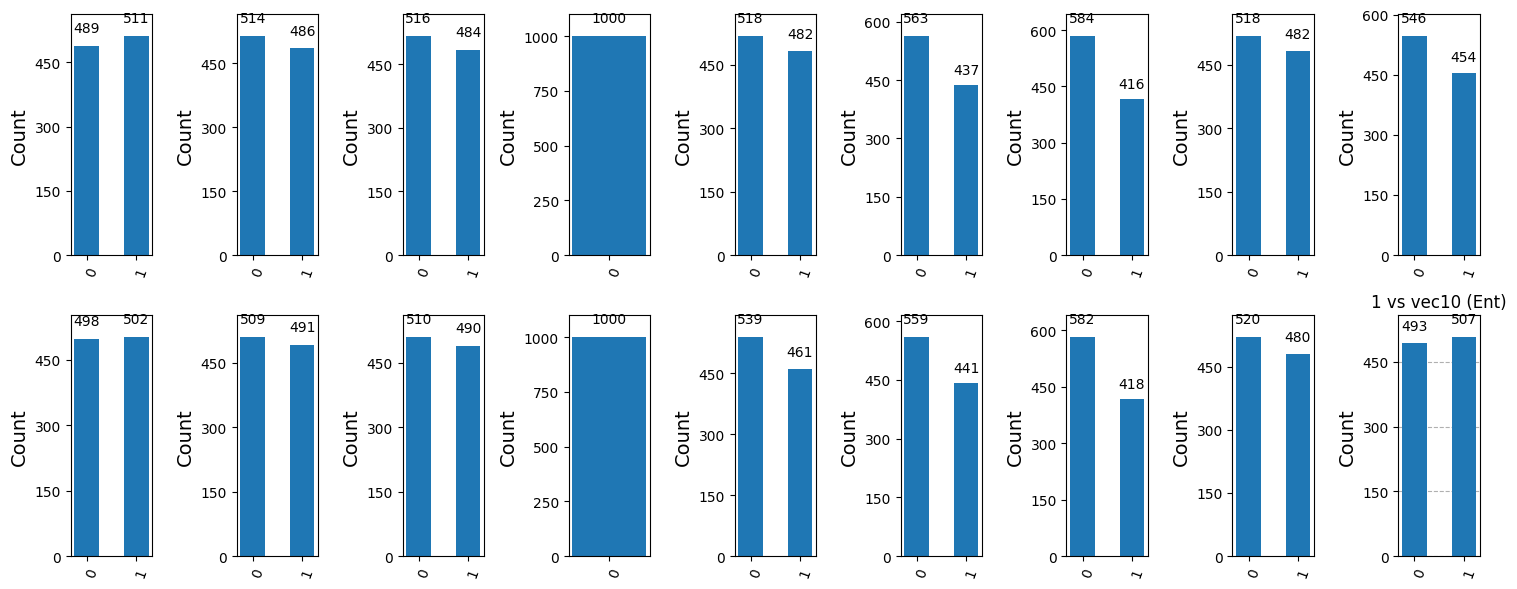

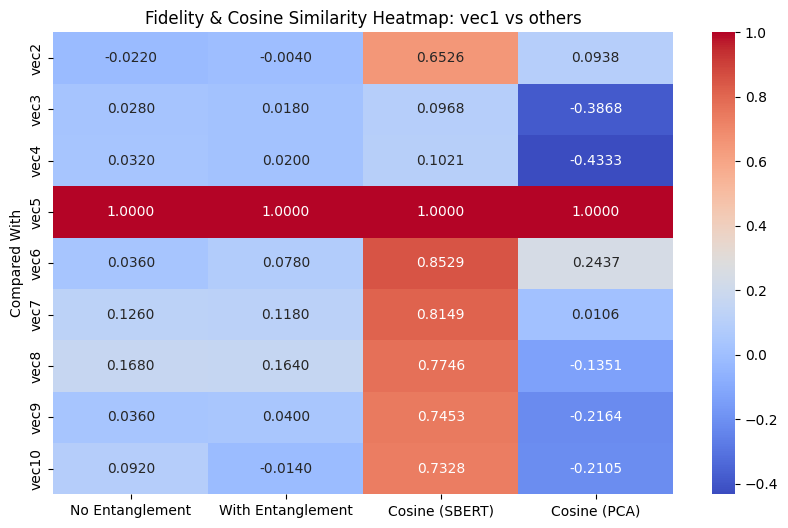

In [55]:
# Run batch comparisons
results_no_ent = batch_compare("vec1", vectors, entangled=False)
results_ent = batch_compare("vec1", vectors, entangled=True)

# maximum fidelity score between vec1 and all other vectors with and without entanglement and print vector key
max_fidelity_no_ent_key = max(results_no_ent.items(), key=lambda x: x[1]['fidelity'])[0]
max_fidelity_ent_key = max(results_ent.items(), key=lambda x: x[1]['fidelity'])[0]
max_fidelity_no_ent = results_no_ent[max_fidelity_no_ent_key]
max_fidelity_ent = results_ent[max_fidelity_ent_key]

print(f"No entanglement - vec1 and {max_fidelity_no_ent_key}, Results: {max_fidelity_no_ent}")
print(f"With entanglement - vec1 and {max_fidelity_ent_key}, Results: {max_fidelity_ent}")

# Plot histograms
fig, axs = plt.subplots(2, len(results_no_ent), figsize=(15, 6))
for i, key in enumerate(results_no_ent.keys()):
    plot_histogram(results_no_ent[key]['counts'], ax=axs[0, i], title=f"1 vs {key} (No Ent)")
    plot_histogram(results_ent[key]['counts'], ax=axs[1, i], title=f"1 vs {key} (Ent)")
plt.tight_layout()
plt.show()

# Create heatmap of fidelities
labels = list(results_no_ent.keys())
fid_matrix = pd.DataFrame({
    'No Entanglement': [results_no_ent[k]['fidelity'] for k in labels],
    'With Entanglement': [results_ent[k]['fidelity'] for k in labels],
    'Cosine (SBERT)': [cosine_full[k] for k in labels],
    'Cosine (PCA)': [cosine_pca[k] for k in labels]
}, index=labels)

plt.figure(figsize=(10, 6))
sns.heatmap(fid_matrix, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Fidelity & Cosine Similarity Heatmap: vec1 vs others")
plt.ylabel("Compared With")
plt.show()
